![Python Logo](./img/python-logo-master-v3-TM-flattened_small.png)

# Financial Programming - IÉSEG, Lille - MBD 2019-2020
## Group Project - Financial Data

In [1]:
first_name = ''
last_name = ''

### Data Exploration

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) 

**Input data**

In [4]:
# Each record describes static characteristics of an account
account = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/account.asc', sep=';')
account.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101
2,704,55,POPLATEK MESICNE,930101
3,2378,16,POPLATEK MESICNE,930101
4,2632,24,POPLATEK MESICNE,930102


In [5]:
# Each record describes a credit card issued to an account
card = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/card.asc', sep=';')
card.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00
2,747,4915,classic,940205 00:00:00
3,70,439,classic,940208 00:00:00
4,577,3687,classic,940215 00:00:00


In [6]:
# Each record describes characteristics of a client
client = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/client.asc', sep=';')
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [7]:
# Each record relates together a client with an account i.e. this relation describes the rights
# of clients to operate accounts
disp = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/disp.asc', sep=';')
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [8]:
# Each record describes characteristics of a payment order
order = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/order.asc', sep=';')
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,


In [9]:
# Each record describes one transaction on an account
trans = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/trans.asc', sep=';', low_memory=False)
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


In [10]:
# Each record describes a loan granted for a given account
loan = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/loan.asc', sep=';')
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [11]:
# Each record describes demographic characteristics of a district.
district = pd.read_csv('C:/Users/hutin/Desktop/IESEG/MASTER BIG DATA/Financial Programming/Group Project_Customer Loan/data_berka/district.asc', sep=';')
district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


# Task description
The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client
(whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses).
Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already
granted, the credit cards issued The bank managers hope to improve their understanding of customers and seek specific
actions to improve services. A mere application of a discovery tool will not be convincing for them.

# 1. Data Preparation
Creating additional variables and cleaning tables, the final goal of this step is to aggregate tables by account and client id to later merge them easily and without duplicate information.

In [12]:
#Adding more demographic variables for segmentation: birth information and gender
client["birth_year"] = ('19'+client["birth_number"].astype(str).str[0:2]).astype(int)
client["birth_day"] = (client["birth_number"].astype(str).str[-2:]).astype(int)
client["birth_month"] = (client["birth_number"].astype(str).str[2:4]).astype(int)
client["g"] = 'M'
client.loc[client["birth_month"]>12,'g'] = 'F'
client.loc[client["birth_month"]>12,'birth_month'] = client['birth_month']-50

In [13]:
cutoff = datetime.datetime(1999, 12, 31, 0, 0).date() #cutoff date for age calculation
client["age"] = 0

for i in range(0,len(client)):
    birth = datetime.date(client.loc[i,"birth_year"],client.loc[i,"birth_month"],client.loc[i,"birth_day"])
    client.loc[i,"age"] = math.floor((cutoff - birth).days/365)
    
client["age_group"] = client["age"]//10*10
client.describe()

,client_id,birth_number,district_id,birth_year,birth_day,birth_month,age,age_group
count,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000
mean,3359.011920,535114.970013,37.310114,1953.198361,15.957161,6.521885,45.831812,41.363382
std,2832.911984,172895.618429,25.043690,17.282283,8.796721,3.432381,17.294283,17.412866
min,1.000000,110820.000000,1.000000,1911.000000,1.000000,1.000000,12.000000,10.000000
25%,1418.000000,406009.000000,14.000000,1940.000000,8.000000,4.000000,31.000000,30.000000
50%,2839.000000,540829.000000,38.000000,1954.000000,16.000000,7.000000,45.000000,40.000000
75%,4257.000000,681013.000000,60.000000,1968.000000,24.000000,9.000000,59.000000,50.000000
max,13998.000000,875927.000000,77.000000,1987.000000,31.000000,12.000000,88.000000,80.000000


In [14]:
client.drop(columns=["birth_number","birth_year","birth_day","birth_month"], inplace=True)

In [15]:
account["frequency"]=account["frequency"].replace("POPLATEK MESICNE", "Monthly Issuance")
account["frequency"]=account["frequency"].replace("POPLATEK PO OBRATU", "Issue after transaction")
account["frequency"]=account["frequency"].replace("POPLATEK TYDNE", "Weekly Issuance")

In [16]:
#Cleaning card table
card["date"] = ('19'+card["issued"].astype(str).str[:2])+'/' \
                        +(card["issued"].astype(str).str[2:4])+'/' \
                        +(card['issued'].astype(str).str[4:6])
card["date"] = pd.to_datetime(card["date"], format='%Y/%m/%d')

card=card.drop("issued", axis=1)

card["card_owner"]= 1 

card.head()

,card_id,disp_id,type,date,card_owner
0,1005,9285,classic,1993-11-07,1
1,104,588,classic,1994-01-19,1
2,747,4915,classic,1994-02-05,1
3,70,439,classic,1994-02-08,1
4,577,3687,classic,1994-02-15,1


In [17]:
order["k_symbol"]=order["k_symbol"].replace("SIPO", "hh_payment")
order["k_symbol"]=order["k_symbol"].replace("UVER", "loan_payment")
order["k_symbol"]=order["k_symbol"].replace("LEASING", "leasing")
order["k_symbol"]=order["k_symbol"].replace("POJISTNE", "insr_payment")
order["k_symbol"]=order["k_symbol"].replace(" ", "Unknown")

In [18]:
#group order by account_id to later merge it
order["leasing"]=0
order["hh_payment"]=0
order["loan_payment"]=0
order["insr_payment"]=0
order.loc[order['k_symbol'] == 'leasing', 'leasing']= order.loc[order['k_symbol'] == 'leasing','amount']
order.loc[order['k_symbol'] == 'hh_payment', 'hh_payment']= order.loc[order['k_symbol'] == 'hh_payment','amount']
order.loc[order['k_symbol'] == 'loan_payment', 'loan_payment']= order.loc[order['k_symbol'] == 'loan_payment','amount']
order.loc[order['k_symbol'] == 'insr_payment', 'insr_payment']= order.loc[order['k_symbol'] == 'insr_payment','amount']

order.drop(columns=["order_id","account_to","k_symbol"], inplace=True)

order=order.groupby(['account_id']).sum().reset_index()
order.head()

,account_id,amount,leasing,hh_payment,loan_payment,insr_payment
0,1,2452.0,0.0,2452.0,0.0,0.0
1,2,10638.7,0.0,7266.0,3372.7,0.0
2,3,5001.0,0.0,1135.0,0.0,3539.0
3,4,3363.0,0.0,3363.0,0.0,0.0
4,5,2668.0,0.0,2668.0,0.0,0.0


In [19]:
district = district.rename(columns={'A1': 'district_id', 'A2': 'dist_name','A3': 'dist_region', 'A4': 'nb_habitants',
                                    'A9': 'nb_cities', 'A10': 'ratio_urban',
                                   'A11': 'avg_salary', 'A12': 'unemp_95','A13': 'unemp_96', 'A14': 'nb_entrepreneurs',
                                   'A15': 'crimes_95', 'A16': 'crimes_96'})
#district=district.drop(["A5","A6","A7","A8","nb_cities","unemp_95","crimes_95"], axis=1)
district=district.drop(["A5","A6","A7","A8","nb_cities"], axis=1)
district.head()

,district_id,dist_name,dist_region,nb_habitants,ratio_urban,avg_salary,unemp_95,unemp_96,nb_entrepreneurs,crimes_95,crimes_96
0,1,Hl.m. Praha,Prague,1204953,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,51.4,9307,3.85,4.43,118,2616,3040


In [20]:
#Turn transaction type into a dummy
trans["credit"] = (trans["type"]=="PRIJEM").astype(int)
trans["withdrawal"] = 0
trans.loc[(trans["type"] == "VYDAJ") | (trans["type"] == "VYBER"),"withdrawal"] = 1

In [21]:
#Turn k symbol into a dummy
trans["k_symbol"].replace({"DUCHOD": "oldage_pension", "POJISTNE": "insurance", "SANKC. UROK":"sanction","SIPO":"household",
                          "SLUZBY":"statement","UROK":"interest","UVER":"loan"},inplace=True)
trans["k_symbol"]=trans["k_symbol"].fillna('UNKNOWN')
trans.loc[trans["k_symbol"]==' ','k_symbol'] = 'UNKNOWN'
trans_dummies = pd.get_dummies(trans[["k_symbol"]])
trans = pd.concat([trans,trans_dummies],axis=1)

In [22]:
#cleaning transaction dates
trans["date_clean"] = ('19'+trans["date"].astype(str).str[0:2])+'/' \
                        +(trans["date"].astype(str).str[2:4])+'/' \
                        +(trans["date"].astype(str).str[-2:])
trans["date_clean"] = pd.to_datetime(trans["date_clean"], format='%Y/%m/%d')
trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,...,withdrawal,k_symbol_UNKNOWN,k_symbol_household,k_symbol_insurance,k_symbol_interest,k_symbol_loan,k_symbol_oldage_pension,k_symbol_sanction,k_symbol_statement,date_clean
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-01
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,UNKNOWN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,1993-01-02


In [23]:
#cleaning loan dates
loan["date"] = ('19'+loan["date"].astype(str).str[0:2])+'/' \
                        +(loan["date"].astype(str).str[2:4])+'/' \
                        +(loan["date"].astype(str).str[-2:])
loan["date"] = pd.to_datetime(loan["date"], format='%Y/%m/%d')
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [24]:
#adding amount to each transaction type and operation
trans["withdrawal"]=(trans["amount"])*trans["withdrawal"]
trans["credit"]=(trans["amount"])*trans["credit"]

trans["k_symbol_household"]=(trans["amount"])*trans["k_symbol_household"]
trans["k_symbol_insurance"]=(trans["amount"])*trans["k_symbol_insurance"]
trans["k_symbol_interest"]=(trans["amount"])*trans["k_symbol_interest"]
trans["k_symbol_loan"]=(trans["amount"])*trans["k_symbol_loan"]
trans["k_symbol_oldage_pension"]=(trans["amount"])*trans["k_symbol_oldage_pension"]
trans["k_symbol_sanction"]=(trans["amount"])*trans["k_symbol_sanction"]
trans["k_symbol_statement"]=(trans["amount"])*trans["k_symbol_statement"]

trans.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,...,withdrawal,k_symbol_UNKNOWN,k_symbol_household,k_symbol_insurance,k_symbol_interest,k_symbol_loan,k_symbol_oldage_pension,k_symbol_sanction,k_symbol_statement,date_clean
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-01
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,UNKNOWN,NaN,NaN,...,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1993-01-02


In [25]:
#average transaction frequency per account
n = 0
acc_datediff = pd.DataFrame(columns=["account_id","datediff"])

for i in pd.unique(trans["account_id"]):
    date_df = trans[trans["account_id"]==i][["date_clean"]]
    date_df.reset_index(drop=True,inplace=True)
    date_df["shift"] = date_df["date_clean"].shift(1)
    date_df["diff"] = (date_df["date_clean"] - date_df["shift"]).astype('timedelta64[D]')
    acc_datediff.loc[n,"account_id"] = i
    acc_datediff.loc[n,"datediff"] = date_df["diff"].mean()
    n += 1

acc_datediff["account_id"] = acc_datediff["account_id"].astype(int)
acc_datediff.head()

,account_id,datediff
0,2378,5.04608
1,576,6.13445
2,704,4.58159
3,3818,3.91771
4,1972,5.94837


In [26]:
#grouping by account id and dropping redundant columns
trans_agg = pysqldf("""Select t.account_id,ad.datediff,min(t.date_clean) as first_trans,max(t.date_clean) as last_trans
                            ,count(t.trans_id) as n_trans,sum(t.amount) as sum_amount,avg(t.amount) as avg_amount
                            ,sum(t.credit) as credit,sum(t.withdrawal) as withdrawal
                            ,sum(t.k_symbol_household) as household_amount,sum(t.k_symbol_insurance) as insurance_amount
                            ,sum(t.k_symbol_interest) as interest_amount,sum(t.k_symbol_loan) as loan_amount
                            ,sum(t.k_symbol_oldage_pension) as pension_amount,sum(t.k_symbol_sanction) as sanction_amount
                            ,sum(t.k_symbol_statement) as statement_amount
                                     from trans t
                                     left join acc_datediff ad on ad.account_id=t.account_id
                                     group by 1,2
                         """)

In [27]:
trans_agg.head()

,account_id,datediff,first_trans,last_trans,n_trans,sum_amount,avg_amount,credit,withdrawal,household_amount,insurance_amount,interest_amount,loan_amount,pension_amount,sanction_amount,statement_amount
0,1,5.789916,1995-03-24 00:00:00.000000,1998-12-31 00:00:00.000000,239,375174.5,1569.767782,194320.5,180854.0,98080.0,0.0,3065.5,0.0,0.0,0.0,584.0
1,2,4.473795,1993-02-26 00:00:00.000000,1998-12-31 00:00:00.000000,478,3151479.3,6593.052929,1597053.5,1554425.8,472290.0,0.0,10717.5,80944.8,0.0,0.0,949.0
2,3,4.672414,1997-07-07 00:00:00.000000,1998-12-31 00:00:00.000000,117,295021.8,2521.553846,173059.0,121962.8,14755.0,46007.0,2070.0,0.0,0.0,0.0,189.8
3,4,5.643243,1996-02-21 00:00:00.000000,1998-12-31 00:00:00.000000,186,350971.4,1886.943011,192346.0,158625.4,60262.0,0.0,2744.0,0.0,188802.0,0.0,423.4
4,5,6.987952,1997-05-30 00:00:00.000000,1998-12-31 00:00:00.000000,84,166881.4,1986.683333,97485.0,69396.4,37352.0,0.0,1562.0,0.0,95323.0,0.0,204.4


In [46]:
trans_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 16 columns):
trans_account_id          4500 non-null int64
trans_datediff            4500 non-null float64
trans_first_trans         4500 non-null object
trans_last_trans          4500 non-null object
trans_n_trans             4500 non-null int64
trans_sum_amount          4500 non-null float64
trans_avg_amount          4500 non-null float64
trans_credit              4500 non-null float64
trans_withdrawal          4500 non-null float64
trans_household_amount    4500 non-null float64
trans_insurance_amount    4500 non-null float64
trans_interest_amount     4500 non-null float64
trans_loan_amount         4500 non-null float64
trans_pension_amount      4500 non-null float64
trans_sanction_amount     4500 non-null float64
trans_statement_amount    4500 non-null float64
dtypes: float64(12), int64(2), object(2)
memory usage: 562.6+ KB


# 2. Merging Dataframes

In [28]:
#Adding prefix to all tables before merging
account = account.add_prefix('acc_')
card = card.add_prefix('cc_')
client = client.add_prefix('cust_')
disp = disp.add_prefix('disp_')
district = district.add_prefix('dist_')
order = order.add_prefix('ord_')
loan = loan.add_prefix('loan_')
trans_agg = trans_agg.add_prefix('trans_')

In [29]:
account_loans = pd.merge(account, loan, how="left",  left_on="acc_account_id",right_on='loan_account_id')
al_trans = pd.merge(account_loans, trans_agg, how="left",  left_on="acc_account_id",right_on='trans_account_id')
alt_disp = pd.merge(al_trans, disp, how="left",  left_on="acc_account_id",right_on='disp_account_id')
altd_card = pd.merge(alt_disp, card, how="left",  left_on="disp_disp_id",right_on='cc_disp_id')
altdc_district = pd.merge(altd_card, district, how="left",  left_on="acc_district_id",right_on='dist_district_id')
altdcd_client = pd.merge(altdc_district, client, how="left",  left_on="disp_client_id",right_on='cust_client_id')
final_merge = pd.merge(altdcd_client, order, how="left",  left_on="acc_account_id",right_on='ord_account_id')

In [47]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 49 columns):
acc_account_id            5369 non-null int64
acc_frequency             5369 non-null object
acc_date                  5369 non-null int64
loan_loan_id              5369 non-null int32
loan_date                 5369 non-null object
loan_amount               5369 non-null int32
loan_duration             5369 non-null int32
loan_payments             5369 non-null int32
loan_status               5369 non-null object
trans_datediff            5369 non-null float64
trans_first_trans         5369 non-null object
trans_last_trans          5369 non-null object
trans_n_trans             5369 non-null int64
trans_sum_amount          5369 non-null float64
trans_avg_amount          5369 non-null float64
trans_credit              5369 non-null float64
trans_withdrawal          5369 non-null float64
trans_household_amount    5369 non-null float64
trans_insurance_amount    5369 non-null float64


In [30]:
#dropping redundant ID columns
keep = ["acc_account_id","loan_loan_id","trans_trans_id","disp_disp_id","cc_card_id","cust_client_id","ord_order_id"]
acc_id = [s for s in final_merge.columns if "_id" in s]
acc_id = [s for s in acc_id if s not in keep]
print(acc_id)

final_merge.drop(columns=acc_id, axis=1, inplace=True)
final_merge.head()

['acc_district_id', 'loan_account_id', 'trans_account_id', 'disp_client_id', 'disp_account_id', 'cc_disp_id', 'dist_district_id', 'cust_district_id', 'ord_account_id']


,acc_account_id,acc_frequency,acc_date,loan_loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,trans_datediff,...,dist_crimes_96,cust_client_id,cust_g,cust_age,cust_age_group,ord_amount,ord_leasing,ord_hh_payment,ord_loan_payment,ord_insr_payment
0,576,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,692,F,64,60,3662.0,0.0,3662.0,0.0,0.0
1,576,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,693,M,64,60,3662.0,0.0,3662.0,0.0,0.0
2,3818,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4601,M,64,60,9135.0,0.0,3596.0,0.0,4065.0
3,3818,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4602,F,65,60,9135.0,0.0,3596.0,0.0,4065.0
4,704,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,4.581590,...,3894,844,M,54,50,3338.0,0.0,2141.0,0.0,0.0


In [31]:
#Shared accounts
shared_accs = final_merge[['cust_client_id','acc_account_id']].groupby('acc_account_id').count()

final_merge[final_merge["acc_account_id"].isin(list(shared_accs[shared_accs['cust_client_id']==2].index))]

,acc_account_id,acc_frequency,acc_date,loan_loan_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status,trans_datediff,...,dist_crimes_96,cust_client_id,cust_g,cust_age,cust_age_group,ord_amount,ord_leasing,ord_hh_payment,ord_loan_payment,ord_insr_payment
0,576,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,692,F,64,60,3662.0,0.0,3662.0,0.0,0.0
1,576,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,6.134454,...,3894,693,M,64,60,3662.0,0.0,3662.0,0.0,0.0
2,3818,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4601,M,64,60,9135.0,0.0,3596.0,0.0,4065.0
3,3818,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,3.917710,...,18347,4602,F,65,60,9135.0,0.0,3596.0,0.0,4065.0
4,704,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,4.581590,...,3894,844,M,54,50,3338.0,0.0,2141.0,0.0,0.0
5,704,Monthly Issuance,930101,NaN,NaT,NaN,NaN,NaN,NaN,4.581590,...,3894,845,F,46,40,3338.0,0.0,2141.0,0.0,0.0
10,793,Monthly Issuance,930103,NaN,NaT,NaN,NaN,NaN,NaN,4.411290,...,5410,950,F,34,30,2267.0,0.0,1212.0,0.0,851.0
11,793,Monthly Issuance,930103,NaN,NaT,NaN,NaN,NaN,NaN,4.411290,...,5410,951,M,39,30,2267.0,0.0,1212.0,0.0,851.0
14,1726,Monthly Issuance,930103,NaN,NaT,NaN,NaN,NaN,NaN,3.640599,...,1717,2093,M,29,20,6709.0,0.0,4438.0,0.0,74.0
15,1726,Monthly Issuance,930103,NaN,NaT,NaN,NaN,NaN,NaN,3.640599,...,1717,2094,F,24,20,6709.0,0.0,4438.0,0.0,74.0


In [32]:
final_merge.describe()

,acc_account_id,acc_date,loan_loan_id,loan_amount,loan_duration,loan_payments,trans_datediff,trans_n_trans,trans_sum_amount,trans_avg_amount,...,dist_nb_entrepreneurs,dist_crimes_96,cust_client_id,cust_age,cust_age_group,ord_amount,ord_leasing,ord_hh_payment,ord_loan_payment,ord_insr_payment
count,5369.000000,5369.000000,827.000000,827.000000,827.000000,827.000000,5369.000000,5369.000000,5.369000e+03,5369.000000,...,5369.000000,5369.000000,5369.000000,5369.000000,5369.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000
mean,2767.496927,951600.734960,6180.746070,151801.538089,36.261185,4231.251511,6.040723,235.169492,1.381196e+06,5690.169751,...,121.235053,16483.837772,3359.011920,45.831812,41.363382,5656.990526,192.451360,3735.299123,818.045307,183.073026
std,2307.843630,14922.683647,681.292733,114577.041848,17.172800,2238.757849,3.545952,127.676758,1.335580e+06,4018.079842,...,23.218265,31481.793856,2832.911984,17.294283,17.412866,3820.924782,715.722002,2948.830228,1949.628119,800.899307
min,1.000000,930101.000000,4959.000000,4980.000000,12.000000,304.000000,2.600583,9.000000,2.940000e+04,843.435519,...,81.000000,888.000000,1.000000,12.000000,10.000000,312.000000,0.000000,0.000000,0.000000,0.000000
25%,1178.000000,931219.000000,5585.000000,67536.000000,24.000000,2495.500000,4.787440,133.000000,4.200838e+05,2271.898765,...,105.000000,2305.000000,1418.000000,31.000000,30.000000,2703.750000,0.000000,1852.000000,0.000000,0.000000
50%,2349.000000,960103.000000,6190.000000,115992.000000,36.000000,3937.000000,5.564356,209.000000,8.756193e+05,4595.870357,...,116.000000,3868.000000,2839.000000,45.000000,40.000000,4456.000000,0.000000,3053.500000,0.000000,0.000000
75%,3526.000000,961103.000000,6760.500000,210564.000000,48.000000,5916.000000,6.335463,330.000000,1.938205e+06,8272.470370,...,132.000000,6295.000000,4257.000000,59.000000,50.000000,7610.250000,0.000000,5288.750000,0.000000,0.000000
max,11382.000000,971229.000000,7308.000000,590820.000000,60.000000,9910.000000,63.750000,675.000000,7.619102e+06,21062.613287,...,167.000000,99107.000000,13998.000000,88.000000,80.000000,22704.300000,4975.200000,14882.000000,9910.000000,12504.000000


In [33]:
#replacing missing values
final_merge["loan_loan_id"]=final_merge["loan_loan_id"].fillna(0).astype(int)          
final_merge["loan_amount"]=final_merge["loan_amount"].fillna(0).astype(int)        
final_merge["loan_duration"]=final_merge["loan_duration"].fillna(0).astype(int)        
final_merge["loan_payments"]=final_merge["loan_payments"].fillna(0).astype(int)        
final_merge["loan_status"]=final_merge["loan_status"].fillna('NA')
final_merge["loan_date"]=final_merge["loan_date"].fillna('999-01-01 00:00:00')
final_merge["cc_card_id"]=final_merge["cc_card_id"].fillna(0).astype(int)
final_merge["cc_type"]=final_merge["cc_type"].fillna('NA')
final_merge["cc_card_owner"]=final_merge["cc_card_owner"].fillna(0).astype(int)
final_merge["cc_date"]=final_merge["cc_date"].fillna('999-01-01 00:00:00')
final_merge["ord_amount"]=final_merge["ord_amount"].fillna(0).astype(int)
final_merge["ord_leasing"]=final_merge["ord_leasing"].fillna(0).astype(int)
final_merge["ord_hh_payment"]=final_merge["ord_hh_payment"].fillna(0).astype(int)
final_merge["ord_loan_payment"]=final_merge["ord_loan_payment"].fillna(0).astype(int)
final_merge["ord_insr_payment"]=final_merge["ord_insr_payment"].fillna(0).astype(int)

In [45]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 49 columns):
acc_account_id            5369 non-null int64
acc_frequency             5369 non-null object
acc_date                  5369 non-null int64
loan_loan_id              5369 non-null int32
loan_date                 5369 non-null object
loan_amount               5369 non-null int32
loan_duration             5369 non-null int32
loan_payments             5369 non-null int32
loan_status               5369 non-null object
trans_datediff            5369 non-null float64
trans_first_trans         5369 non-null object
trans_last_trans          5369 non-null object
trans_n_trans             5369 non-null int64
trans_sum_amount          5369 non-null float64
trans_avg_amount          5369 non-null float64
trans_credit              5369 non-null float64
trans_withdrawal          5369 non-null float64
trans_household_amount    5369 non-null float64
trans_insurance_amount    5369 non-null float64


# Plots
Plots have been created for exploratory purposes to better understand client profiles

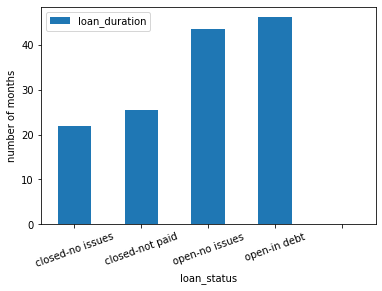

In [34]:
ax = final_merge["loan_duration"].groupby(by=final_merge['loan_status']).mean().plot.bar(legend=True)
ax.set_ylabel("number of months")
plt.xticks(rotation=20)
ax.set_xticklabels(["closed-no issues","closed-not paid","open-no issues","open-in debt"])
plt.savefig('fig_'+str('loan_status_amount')+'.png', dpi=200,bbox_inches="tight")
plt.show()

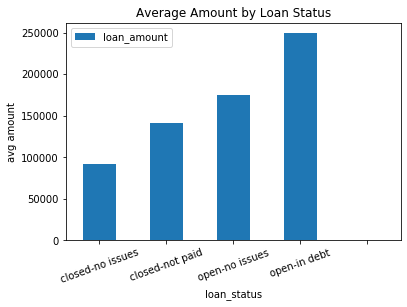

In [35]:
ax = final_merge["loan_amount"].groupby(by=final_merge['loan_status']).mean().plot.bar(legend=True)
ax.set_ylabel("avg amount")
plt.xticks(rotation=20)
ax.set_xticklabels(["closed-no issues","closed-not paid","open-no issues","open-in debt"])
plt.title('Average Amount by Loan Status')
plt.savefig('fig_'+str('loan_duration_all')+'.png', dpi=200,bbox_inches="tight")
plt.show()

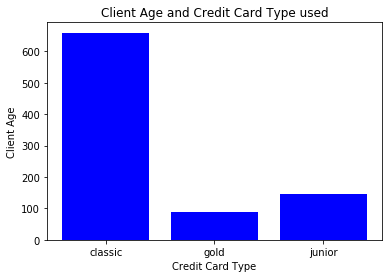

In [36]:
#what is this plot saying?
f = plt.figure(1)
df = final_merge.groupby('cc_type')['cust_client_id'].count()
y = df[1:]
x = list(df.index)[1:]
plt.xlabel('Credit Card Type')
plt.ylabel('Client Age')
plt.bar(x, y,color='blue')
plt.title('Client Age and Credit Card Type used')
plt.savefig('fig_'+str('Client Age and Account type used')+'.png', dpi=200,bbox_inches="tight")
plt.show()

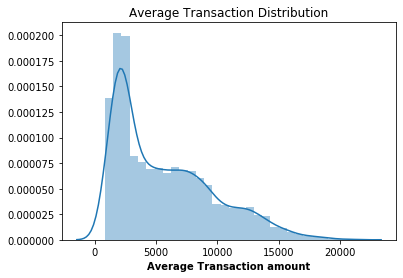

In [37]:
sns.distplot(final_merge['trans_avg_amount'])
plt.xlabel('Average Transaction amount', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Average Transaction Distribution')
plt.savefig('fig_'+str('Average Transaction Distribution')+'.png', dpi=200,bbox_inches="tight")
#plt.show()

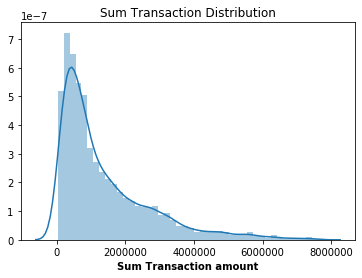

In [38]:
sns.distplot(final_merge['trans_sum_amount'])
plt.xlabel('Sum Transaction amount', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Sum Transaction Distribution')
plt.savefig('fig_'+str('Sum Transaction Distribution')+'.png', dpi=200,bbox_inches="tight")
#plt.show()

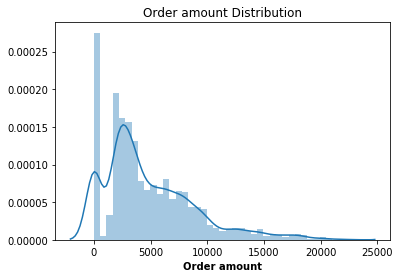

In [39]:
sns.distplot(final_merge['ord_amount'])
plt.xlabel('Order amount', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Order amount Distribution')
plt.savefig('fig_'+str('Order amount Distribution')+'.png', dpi=200,bbox_inches="tight")
#plt.show()

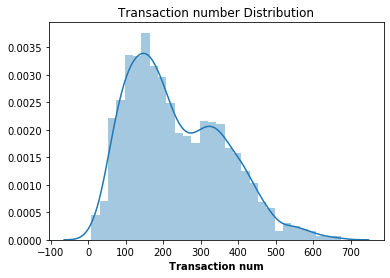

In [40]:
sns.distplot(final_merge['trans_n_trans'])
plt.xlabel('Transaction num', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
plt.title('Transaction number Distribution')
plt.savefig('fig_'+str('Transaction number Distribution')+'.png', dpi=200,bbox_inches="tight")
#plt.show()